<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C4W2_4_Time_series_TSN_Multi_Dense_learning_rate_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#!pip install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


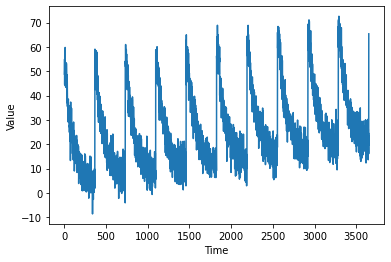

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 0
amplitude = 50
slope = 0.005
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
my_epochs = 100

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=my_epochs,verbose=1)

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#model.compile(loss="mse", optimizer=optimizer)
#history = model.fit(dataset, epochs=my_epochs, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
94/94 [==============================] - 0s 5ms/step - loss: 193.8194
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 59.2799
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 53.1053
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 49.9611
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 47.9590
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 42.0980
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 38.4186
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 37.0389
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 36.1168
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 35.6205
Epoch 11/100
94/94 [==============================] - 0s 5ms/step - loss: 34.8777
Epoch 12/100
94/94 [==============================] - 1s 6ms/step - loss: 34.4226
Epoch 13/100
94/94 [====

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


(1e-08, 0.001, 0.0, 300.0)

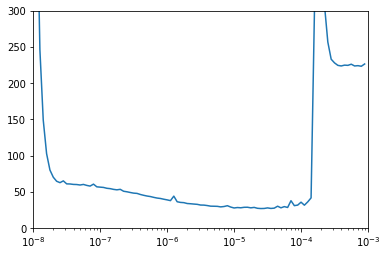

In [0]:
lrs = 1e-8 * (10 ** (np.arange(my_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

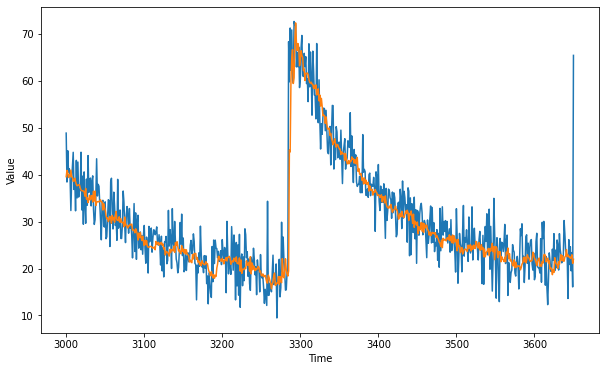

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

3.574421

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=my_epochs,verbose=1)

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
#model.compile(loss="mse", optimizer=optimizer)
#history = model.fit(dataset, epochs=my_epochs, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
94/94 [==============================] - 0s 3ms/step - loss: 122.3631
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 39.3626
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 33.6919
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 31.2189
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 29.9984
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 29.7841
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 29.0774
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 28.8593
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 31.8971
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 28.4122
Epoch 11/100
94/94 [==============================] - 0s 5ms/step - loss: 32.2410
Epoch 12/100
94/94 [==============================] - 0s 5ms/step - loss: 28.1112
Epoch 13/100
94/94 [====

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


(1e-08, 0.001, 0.0, 300.0)

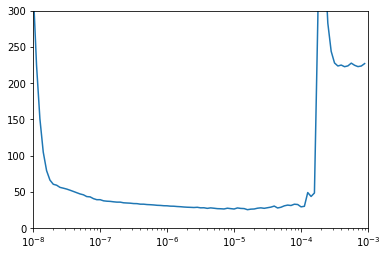

In [0]:
lrs = 1e-8 * (10 ** (np.arange(my_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

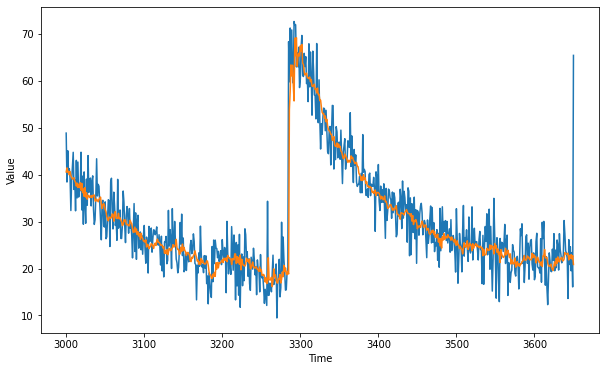

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUThi
# A Value less than 3

3.5475323